## ReaDESeq Go!: An Introduction into DESeq2 Differential Expression and PCA
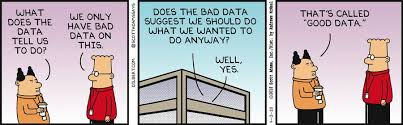

Let's import the libraries we need:

In [1]:
library("DESeq2")
library("ggplot2")
library("RColorBrewer")
library("IRdisplay")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, as.vector, cbind, colnames, do.call, duplicated,
    eval, evalq, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges


Because DESeq2 works with matrices and uses row names as identifies we load our data accordingly

In [2]:
counts <- read.csv('~/scratch/featureCounts/counts_for_deseq2.csv', header=TRUE, row.names=1)
head(counts)


,X.home.ucsd.train58.scratch.testing.star_alignment.DMSO_1_ATCACGAligned.out.sorted.bam,X.home.ucsd.train58.scratch.testing.star_alignment.DMSO_2_CGATGTAligned.out.sorted.bam,X.home.ucsd.train58.scratch.testing.star_alignment.DTP_1_CAGATCAligned.out.sorted.bam,X.home.ucsd.train58.scratch.testing.star_alignment.DTP_2_CCGTCCAligned.out.sorted.bam,X.home.ucsd.train58.scratch.testing.star_alignment.DTP_3_GTGAAAAligned.out.sorted.bam
ENSG00000223972.4,0,0,0,0,0
ENSG00000227232.4,16,19,44,38,61
ENSG00000243485.2,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0
ENSG00000268020.2,0,0,0,0,0
ENSG00000240361.1,0,0,0,0,0


We also need our condition identifiers so DESeq2 know what to compare against what


In [3]:
condition <- factor(c("DMSO","DMSO","DTP","DTP","DTP"))

Using our featurecounts processed data we don't have to do any data normalization since DESeq2 will do that for us. Instead we only have to format our data so DESeq2 can analyze it. More analysis details can be found in the [example page](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) of DESeq2.

First, we will define experimental parameters. If using a counts matrix, we will use the following function, where countData is equal to our counts matrix (our `counts` variable), colData is equal to our conditions (which we just defined above), and design accounts for how we wish to model our effect (in this case, by the "condition" or treatment with a specific drug or shRNA). The factor variable, in this case `condition`, needs to be columns of coldata:

In [4]:
dds <- DESeqDataSetFromMatrix(countData = counts, colData = DataFrame(condition), design = ~condition)

Remember from our python analysis - to get rid of noise we dropped rows that have RPKM less than 4. For our DESeq2 analysis we can do the same thing

In [5]:
dds <- dds[rowSums(counts(dds)) > 4,] 

Ok lets run DESeq:

In [6]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


It's likely prudent to save our results so we can go ahead and do that below:

In [7]:
res <- results(dds)
write.csv(as.data.frame(res), file="~/scratch/featureCounts/differential_expression.csv")
summary(res)



out of 27626 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 6314, 23% 
LFC < 0 (down)   : 6790, 25% 
outliers [1]     : 0, 0% 
low counts [2]   : 3214, 12% 
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



What exactly is happening above? Well from the documentation (and at a high-level) results() extracts a table of results from the DESeq analysis. But what results - well specifically it gives the base means across samples, log2 fold changes, standard errors, test statistics, p-values and adjusted p-values

### Visualizing Differential Expression and PCA:

The function [plotMA](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/plotMA) allows us to plot the log2 fold changes over the mean of normalized counts for all the samples in dds. Points are colored red if the adjusted p value (alpha) is less than 0.1. Points which fall out of the window are plotted as open triangles pointing either up or down. The window can be widened using the ylim argument

<br>**Oh no - Package Incompatibility Issues Ahead:**  Remember in the instructions when I mentioned that installations can be finicky and package incompatability can be a real pain to resolve. Well we are (likely) about to run into that here. Across packages in R, there seems to be an issue between the plotting library, R, the irKernel, and a package Cairo. 

Specifically, what happens is that when attempting to plot, R generates an intermediate pdf in the current directory and then when rendering in the notebook there is a disconnect where the plotting library cannot read in the intermediate pdf file. The fix for this is laborious and time-intensive (essentially we would need to re-install R), so let's see if we can finagle things to our advantage without all of us having to re-install R.

Let's _"intercept this pdf in transit"_ and use it to our advantage. By this I mean we can preempt issues from developing by directing the intermediate pdf to a definite file that we can view easily. This allows us to view all our plots in our current directory (you can select images after generation and they should show up in a separate tab), but the mildly annoying part is that we don't get to see these plots in our notebook.<br><br><br>


In [8]:
pdf("DESeq2_Baseline.pdf")
plotMA(res, main="DESeq2", ylim=c(-2,2))
dev.off()


pdf 
  2

We can also get a more stringent view of our differentially expressed genes by rerunning result on dds with an additional argument alpha. This allows us to be more discerning with our adjusted p value threshold, in this case allowing us to decrease the cutoff to alpha=0.05

In [9]:
pdf("DESeq2_AlphaCutoff.pdf")
res05 <- results(dds, alpha=0.05)
plotMA(res05, main="alpha=0.05", ylim=c(-2,2))
dev.off()

pdf 
  2

Okay now jump to your pdfs and toggle between the two images you generated? Hopefully you notice the difference!


Now let's graph our individual samples using Principal Component Analysis (PCA). This allows us to assess overall variance within our experiment by defining principal components. This plot will show our samples in a 2D plane spanned by their first two principal components. This is useful for visualizing the overall effect of experimental covariates, in this case shRNA treatment, as well as batch effects that may confound findings. For a more thorough explanation of PCA, you might find this [notebook](https://github.com/biom262/biom262-2019/blob/master/Module_2/Tutorials/Intro_to_PCA.ipynb) to be helpful.

**Note:** [plotPCA](https://www.rdocumentation.org/packages/DESeq2/versions/1.12.3/topics/plotPCA) takes in a DESeqTransform object - produced either by rlog or varianceStabilizingTransformation. You can include either here - in fact we will run both, but as a baseline we will plot rlog as it is more robust than vsd. However feel free to run both if your curious! 

At a high-level these transforms are performed due to the inherent nature of RNA-seq data (variance tends to grow with the mean). Specifically PCA performed directly on the matrix of normalized read counts usually depends on a few highly expressed genes. Rlog and vsd attempt to make the data homoskedatic (think constant variance) and provide a more robust PCA input (though this does not account for [batch correction](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#why-after-vst-are-there-still-batches-in-the-pca-plot)). If interested a more thorough explanation can be found [here](https://bioc.ism.ac.jp/packages/2.14/bioc/vignettes/DESeq2/inst/doc/beginner.pdf) (see pages 25-26).

In [10]:
pdf("PCA.pdf")
rld <- rlog(dds) 
vsd <- varianceStabilizingTransformation(dds)
data <- plotPCA(rld, intgroup="condition", returnData=TRUE) 
percentVar <- round(100 * attr(data, "percentVar")) 
ggplot(data, aes(PC1, PC2, color=condition)) + geom_point(size=3) + xlab(paste0("PC1: ",percentVar[1],"% variance")) + ylab(paste0("PC2: ",percentVar[2],"% variance")) 
dev.off()

pdf 
  2

In [11]:
100 * attr(data, "percentVar")

[1] 99.2748800  0.2871378

As we can see, 99% of variance at the gene level is attibutable to PC1, along which our experimental conditions cluster separately. Thus, we have reasonably high confidence that out treatment is the main source of variance in our experiment.

Similarly, this can also be visualized via heatmap, which summarizes sample-to-sample similarities via hierarchical clustering:

In [12]:
pdf("Heatmap.pdf")
sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(rld$condition)
colnames(sampleDistMatrix) <- paste(rld$condition)
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
heatmap(sampleDistMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, col=colors)
dev.off()

Warning message:
In plot.window(...): "clustering_distance_rows" is not a graphical parameterWarning message:
In plot.window(...): "clustering_distance_cols" is not a graphical parameterWarning message:
In plot.xy(xy, type, ...): "clustering_distance_rows" is not a graphical parameterWarning message:
In plot.xy(xy, type, ...): "clustering_distance_cols" is not a graphical parameterWarning message:
In title(...): "clustering_distance_rows" is not a graphical parameterWarning message:
In title(...): "clustering_distance_cols" is not a graphical parameter

pdf 
  2

In [14]:
sampleDistMatrix

,DMSO,DMSO,DTP,DTP,DTP
DMSO,0.00000,20.86563,72.93191,75.15317,74.63407
DMSO,20.86563,0.00000,72.84606,75.11664,74.64496
DTP,72.93191,72.84606,0.00000,21.10991,22.58524
DTP,75.15317,75.11664,21.10991,0.00000,21.76806
DTP,74.63407,74.64496,22.58524,21.76806,0.00000
